## Model RoBERTa

In [1]:
import pandas as pd
import torch

In [2]:
dataset = pd.read_csv("../data/final_dataset.csv")
dataset

,text,labels,id,author,subreddit,created_utc
0,My favourite food is anything I didn't have to...,[27],eebbqej,Rockzilla78,KitchenConfidential,2019-01-18
1,"Now if he does off himself, everyone will thin...",[27],ed00q6i,cocaineluna,morbidquestions,2019-01-01
2,WHY THE FUCK IS BAYLESS ISOING,[2],eezlygj,minnesotagoat_,timberwolves,2019-01-26
3,To make her feel threatened,[14],ed7ypvh,AlexNic1013,askwomenadvice,2019-01-04
4,Dirty Southern Wankers,[3],ed0bdzj,having_a_nap,london,2019-01-01
...,...,...,...,...,...,...
54258,Thanks. I was diagnosed with BP 1 after the ho...,[15],efeeasc,scaredyk4t,bipolar,2019-01-30
54259,Well that makes sense.,[4],ef9c7s3,LX_Emergency,ABoringDystopia,2019-01-29
54260,Daddy issues [NAME],[27],efbiugo,your_ex_girlfriend-,SquaredCircle,2019-01-30
54261,So glad I discovered that subreddit a couple m...,[0],efbvgp9,Paladin-Arda,AskALiberal,2019-01-30


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cuda


### Preprocessing

I convert each `dataset['labels']` into a fixed-lenght 0/1 vector beacuse:
1. multi-label encoding
    + we have a list like `[2, 14, 27]` that tells us which classes are present, a multi-hot vector of lenght 28 `[0,0,1,0,...,1]` tells us which of the 28 possible emotions are active (1) or inactive (0) in a tensor
2. Model expectation
    + In Hugging Face's `problem_type="multi_label_classification"` the model uses a binary-cross-entropy loss with logits. That loss requires, for each example, a float tensor of shape `[num_labels]` with 0.0/1.0 targets, not a list of indices
3. Clear interpretation and metric calculation
    + Post-inference we'll get model outputs of shape `[batch_size, 28]`

In [4]:
import re

In [5]:
type(dataset['labels'][0])

str

In [6]:
def parse_label(label):
    nums = re.findall(r'\d+', label)
    return [int(n) for n in nums]

dataset['labels'] = dataset['labels'].apply(parse_label)

In [7]:
type(dataset['labels'][0])

list

In [8]:
def convert_labels_to_multihot(l):
    vec = [0] * 28
    for idx in l:
        vec[idx] = 1
    return vec

dataset['labels_multihot'] = dataset['labels'].apply(convert_labels_to_multihot)

In [9]:
dataset

,text,labels,id,author,subreddit,created_utc,labels_multihot
0,My favourite food is anything I didn't have to...,[27],eebbqej,Rockzilla78,KitchenConfidential,2019-01-18,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,"Now if he does off himself, everyone will thin...",[27],ed00q6i,cocaineluna,morbidquestions,2019-01-01,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,WHY THE FUCK IS BAYLESS ISOING,[2],eezlygj,minnesotagoat_,timberwolves,2019-01-26,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,To make her feel threatened,[14],ed7ypvh,AlexNic1013,askwomenadvice,2019-01-04,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
4,Dirty Southern Wankers,[3],ed0bdzj,having_a_nap,london,2019-01-01,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...,...
54258,Thanks. I was diagnosed with BP 1 after the ho...,[15],efeeasc,scaredyk4t,bipolar,2019-01-30,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
54259,Well that makes sense.,[4],ef9c7s3,LX_Emergency,ABoringDystopia,2019-01-29,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
54260,Daddy issues [NAME],[27],efbiugo,your_ex_girlfriend-,SquaredCircle,2019-01-30,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
54261,So glad I discovered that subreddit a couple m...,[0],efbvgp9,Paladin-Arda,AskALiberal,2019-01-30,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [10]:
label = dataset['labels'][0]
multi_hot = dataset['labels_multihot'][0]

print(f"label = {label}") # neutral
print(f"label multi-hot = {multi_hot}")

label = [27]
label multi-hot = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]


In [11]:
dataset = dataset.drop(columns=['labels'])

In [12]:
dataset = dataset.rename(columns={'labels_multihot': 'labels'})

In [13]:
dataset.columns

Index(['text', 'id', 'author', 'subreddit', 'created_utc', 'labels'], dtype='object')

### Train-Validation-Test split

In [14]:
from sklearn.model_selection import train_test_split
from collections import Counter

In [15]:
X = dataset.drop(columns=['labels'])
y = dataset['labels']

# split train-test
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, 
    test_size=5427,   # original size of test set
    random_state=42)

# split train-validation
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, 
    test_size=5426,   # original size of validation set
    random_state=42)

In [16]:
print(f"Length training set = {len(X_train)}")
print(f"Length validation set = {len(X_val)}")
print(f"Length testing set = {len(X_test)}")

Length training set = 43410
Length validation set = 5426
Length testing set = 5427


### Tokenization

In [17]:
from transformers import AutoTokenizer

/home/biso/Uni/corsi/uni_venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [18]:
model_name = "roberta-base"

tokenizer = AutoTokenizer.from_pretrained(model_name)

train_encodings = tokenizer(
    list(X_train['text']),
    truncation=True,
    padding="max_length",
    max_length=128,
    return_tensors="pt"
)

val_encodings = tokenizer(
    list(X_val['text']),
    truncation=True,
    padding="max_length",
    max_length=128,
    return_tensors="pt" 
)

test_encodings = tokenizer(
    list(X_test['text']),
    truncation=True,
    padding="max_length",
    max_length=128,
    return_tensors="pt"
)

In [19]:
idx = 0

# original
print(f"Original: {X_train.iloc[idx]['text']}")

print("---------------------------------")

# token_id and attention mask
print(f"Token IDs: {train_encodings['input_ids'][idx][:10]}")
print(f"Attention mask: {train_encodings['attention_mask'][idx][:10]}")

print("---------------------------------")

# show tokens
tokens = tokenizer.convert_ids_to_tokens(train_encodings['input_ids'][idx])
print(f"Tokenized: {tokens[:10]}")

Original: Hahaha exactly, and deciding on even the most simple of things
---------------------------------
Token IDs: tensor([    0,   725,   895, 11695,  2230,     6,     8,  8997,    15,   190])
Attention mask: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
---------------------------------
Tokenized: ['<s>', 'H', 'ah', 'aha', 'Ġexactly', ',', 'Ġand', 'Ġdeciding', 'Ġon', 'Ġeven']


### Model 

In [20]:
from transformers import AutoConfig
from transformers import AutoModelForSequenceClassification
import json

In [21]:
emotions = [
    "admiration", "amusement", "anger", "annoyance", "approval",
    "caring", "confusion", "curiosity", "desire", "disappointment",
    "disapproval", "disgust", "embarrassment", "excitement", "fear",
    "gratitude", "grief", "joy", "love", "nervousness", "optimism",
    "pride", "realization", "relief", "remorse", "sadness", "surprise", "neutral"
]

In [22]:
label2id = {name: idx for idx, name in enumerate(emotions)}
id2label = {idx: name for name, idx in label2id.items()}

config = AutoConfig.from_pretrained(model_name)
config.num_labels = len(emotions)
config.problem_type = "multi_label_classification"
config.id2label = id2label
config.label2id = label2id

model = AutoModelForSequenceClassification.from_pretrained(model_name, config=config)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [23]:
print(f"Problem type: {model.config.problem_type}")

Problem type: multi_label_classification


In [24]:
print(json.dumps(model.config.to_dict(), indent=4))

{
    "return_dict": true,
    "output_hidden_states": false,
    "output_attentions": false,
    "torchscript": false,
    "torch_dtype": "float32",
    "use_bfloat16": false,
    "tf_legacy_loss": false,
    "pruned_heads": {},
    "tie_word_embeddings": true,
    "chunk_size_feed_forward": 0,
    "is_encoder_decoder": false,
    "is_decoder": false,
    "cross_attention_hidden_size": null,
    "add_cross_attention": false,
    "tie_encoder_decoder": false,
    "max_length": 20,
    "min_length": 0,
    "do_sample": false,
    "early_stopping": false,
    "num_beams": 1,
    "num_beam_groups": 1,
    "diversity_penalty": 0.0,
    "temperature": 1.0,
    "top_k": 50,
    "top_p": 1.0,
    "typical_p": 1.0,
    "repetition_penalty": 1.0,
    "length_penalty": 1.0,
    "no_repeat_ngram_size": 0,
    "encoder_no_repeat_ngram_size": 0,
    "bad_words_ids": null,
    "num_return_sequences": 1,
    "output_scores": false,
    "return_dict_in_generate": false,
    "forced_bos_token_id": null

In [25]:
print(f"Number of labels: {model.config.num_labels}")
print("--------------------------------------------")
map_labels = model.config.id2label
for idx in sorted(map_labels.keys()):
    print(f"Index {idx} -> {map_labels[idx]}")

Number of labels: 28
--------------------------------------------
Index 0 -> admiration
Index 1 -> amusement
Index 2 -> anger
Index 3 -> annoyance
Index 4 -> approval
Index 5 -> caring
Index 6 -> confusion
Index 7 -> curiosity
Index 8 -> desire
Index 9 -> disappointment
Index 10 -> disapproval
Index 11 -> disgust
Index 12 -> embarrassment
Index 13 -> excitement
Index 14 -> fear
Index 15 -> gratitude
Index 16 -> grief
Index 17 -> joy
Index 18 -> love
Index 19 -> nervousness
Index 20 -> optimism
Index 21 -> pride
Index 22 -> realization
Index 23 -> relief
Index 24 -> remorse
Index 25 -> sadness
Index 26 -> surprise
Index 27 -> neutral


In [26]:
from torch.optim import AdamW
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import os
import torch.nn as nn

In [27]:
class EmotionDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = list(labels)
    
    def __getitem__(self, index):
        item = {key: value[index] for key, value in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[index])
        return item
    
    def __len__(self):
        return len(self.labels)

In [28]:
train_dataset = EmotionDataset(train_encodings, y_train)
val_dataset = EmotionDataset(val_encodings, y_val)
test_dataset = EmotionDataset(test_encodings, y_test)

In [29]:
for i in range(3):
    example = train_dataset[i]
    print(f"\nSample {i}")
    print(f"Tokens: {tokenizer.convert_ids_to_tokens(example['input_ids'][:10])}")
    print(f"Label: {example['labels']}")


Sample 0
Tokens: ['<s>', 'H', 'ah', 'aha', 'Ġexactly', ',', 'Ġand', 'Ġdeciding', 'Ġon', 'Ġeven']
Label: tensor([0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0])

Sample 1
Tokens: ['<s>', 'Sweet', 'Ġthanks', 'Ġfor', 'Ġthe', 'Ġupdate', '.', 'ĠI', 'Ġhope', 'Ġthe']
Label: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0])

Sample 2
Tokens: ['<s>', 'Science', 'Ġis', 'Ġmeasuring', 'Ġwhat', 'Ġwe', 'Ġsee', '.', 'ĠI', 'Ġalso']
Label: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1])


In [30]:
save_path = "../best_model_RoBERTa"

In [71]:
model.to(device)

train_batch_size = 16
val_batch_size = 64
n_epochs = 4
learning_rate = 2e-5

# dataloader
train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=val_batch_size)

optimizer = AdamW(model.parameters(), lr=learning_rate)

best_f1 = 0.0
os.makedirs(save_path, exist_ok=True)

loss_fn = nn.BCEWithLogitsLoss()

for epoch in range(n_epochs):
    model.train()
    total_loss = 0

    print(f"\n Epoch {epoch+1}/{n_epochs}")

    for batch in tqdm(train_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device).float()

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        loss = loss_fn(logits, labels)

        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_train_loss = total_loss/len(train_loader)
    print(f"✅ Training Loss: {avg_train_loss:.4f}")

    # -- validation --
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device).float()
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = (torch.sigmoid(logits) >= 0.5).int()

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    print(f"Validation accuracy = {accuracy:4f} | F1 score = {f1:4f}")

    if f1 > best_f1:
        best_f1 = f1
        model.save_pretrained(save_path)

tokenizer.save_pretrained(save_path)
print(f"✅ Modello e tokenizer salvati in: {save_path}")


 Epoch 1/4


100%|██████████| 2714/2714 [10:25<00:00,  4.34it/s]


✅ Training Loss: 0.1204
Validation accuracy = 0.393107 | F1 score = 0.471962

 Epoch 2/4


100%|██████████| 2714/2714 [10:27<00:00,  4.32it/s]


✅ Training Loss: 0.0857
Validation accuracy = 0.422595 | F1 score = 0.521836

 Epoch 3/4


100%|██████████| 2714/2714 [10:26<00:00,  4.33it/s]


✅ Training Loss: 0.0760
Validation accuracy = 0.447107 | F1 score = 0.546674

 Epoch 4/4


100%|██████████| 2714/2714 [10:26<00:00,  4.33it/s]


✅ Training Loss: 0.0679
Validation accuracy = 0.459454 | F1 score = 0.557044
✅ Modello e tokenizer salvati in: ./best_model_RoBERTa


### Testing

In [31]:
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt
import numpy as np 
from collections import Counter

In [32]:
model = AutoModelForSequenceClassification.from_pretrained(save_path).to(device)
tokenizer = AutoTokenizer.from_pretrained(save_path)
model.eval()

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [33]:
emotions = [
    "admiration", "amusement", "anger", "annoyance", "approval",
    "caring", "confusion", "curiosity", "desire", "disappointment",
    "disapproval", "disgust", "embarrassment", "excitement", "fear",
    "gratitude", "grief", "joy", "love", "nervousness", "optimism",
    "pride", "realization", "relief", "remorse", "sadness", "surprise", "neutral"
]

In [34]:
test_batch_size = 64
test_loader = DataLoader(test_dataset, batch_size=test_batch_size)

all_logits = []
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device).int()

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits  # [batch_size, num_labels]

        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).int()

        for i in range(preds.size(0)):
            if preds[i].sum() == 0:
                top_idx = torch.argmax(probs[i]).item()
                preds[i, top_idx] = 1

        all_logits.extend(logits.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

# test set results
print("\nTest set results:")
print(f"- Accuracy = {accuracy:4f}")
print(f"- Precision = {precision:4f}")
print(f"- Recall = {recall:4f}")
print(f"- F1 score = {f1:4f}")

print("\nClassification report per emotion")
print(classification_report(all_labels, all_preds, target_names=emotions, zero_division=0))


Test set results:
- Accuracy = 0.491985
- Precision = 0.596712
- Recall = 0.545426
- F1 score = 0.561719

Classification report per emotion
                precision    recall  f1-score   support

    admiration       0.67      0.76      0.71       547
     amusement       0.75      0.86      0.80       270
         anger       0.56      0.45      0.50       192
     annoyance       0.37      0.21      0.27       304
      approval       0.45      0.29      0.35       368
        caring       0.35      0.55      0.43       143
     confusion       0.52      0.36      0.43       136
     curiosity       0.46      0.51      0.48       252
        desire       0.55      0.56      0.55        84
disappointment       0.33      0.24      0.28       152
   disapproval       0.44      0.29      0.35       260
       disgust       0.39      0.46      0.42       106
 embarrassment       0.58      0.58      0.58        33
    excitement       0.59      0.39      0.47       105
          fear    

### Show predictions

In [35]:
def print_predictions(idx):
    # logits
    logits_tensor = torch.tensor(all_logits[idx])
    # probability
    probs_tensor = torch.sigmoid(logits_tensor)
    # apply threshold
    preds_tensor = (probs_tensor > 0.5).int()

    if preds_tensor.sum()==0:
        top_idx = torch.argmax(probs_tensor).item()
        preds_tensor[top_idx] = 1

    GREEN = "\033[92m"
    RESET = "\033[0m"

    for i in range(len(preds_tensor)):
        color = GREEN if preds_tensor[i] == 1 else RESET
        print(f"{color}[{i}] {emotions[i]} | Logits: {logits_tensor[i]:.4f} -> Prob: {probs_tensor[i]:.4f}{RESET}")

    # print predictions
    print(f"\nPredictions: {[emotions[i] for i in range(len(preds_tensor)) if preds_tensor[i] == 1]}")

    # original text
    print(f"\nOriginal text: \"{X_test['text'].iloc[idx]}\"")

In [36]:
# example on one sample of the test set
idx = 30

print_predictions(idx)

[0] admiration | Logits: -3.8199 -> Prob: 0.0215
[1] amusement | Logits: -6.6657 -> Prob: 0.0013
[2] anger | Logits: -3.7087 -> Prob: 0.0239
[3] annoyance | Logits: -2.6011 -> Prob: 0.0691
[4] approval | Logits: -4.8901 -> Prob: 0.0075
[5] caring | Logits: -6.6550 -> Prob: 0.0013
[6] confusion | Logits: -5.6507 -> Prob: 0.0035
[7] curiosity | Logits: -5.7104 -> Prob: 0.0033
[8] desire | Logits: -6.0147 -> Prob: 0.0024
[9] disappointment | Logits: -0.5382 -> Prob: 0.3686
[10] disapproval | Logits: -3.4710 -> Prob: 0.0301
[11] disgust | Logits: -0.3801 -> Prob: 0.4061
[12] embarrassment | Logits: -2.6893 -> Prob: 0.0636
[13] excitement | Logits: -6.8307 -> Prob: 0.0011
[14] fear | Logits: -4.9174 -> Prob: 0.0073
[15] gratitude | Logits: -6.9536 -> Prob: 0.0010
[16] grief | Logits: -5.8919 -> Prob: 0.0028
[17] joy | Logits: -6.3344 -> Prob: 0.0018
[18] love | Logits: -5.7282 -> Prob: 0.0032
[19] nervousness | Logits: -5.7118 -> Prob: 0.0033
[20] optimism | Logits: -4.0802 -> Prob: 0.0166


In [37]:
idx = 450

print_predictions(idx)

[0] admiration | Logits: -7.3477 -> Prob: 0.0006
[1] amusement | Logits: -6.1265 -> Prob: 0.0022
[2] anger | Logits: -6.8163 -> Prob: 0.0011
[3] annoyance | Logits: -5.4586 -> Prob: 0.0042
[4] approval | Logits: -3.7938 -> Prob: 0.0220
[5] caring | Logits: -5.0737 -> Prob: 0.0062
[6] confusion | Logits: -6.6603 -> Prob: 0.0013
[7] curiosity | Logits: -6.4976 -> Prob: 0.0015
[8] desire | Logits: -4.3378 -> Prob: 0.0129
[9] disappointment | Logits: -4.7882 -> Prob: 0.0083
[10] disapproval | Logits: -6.3845 -> Prob: 0.0017
[11] disgust | Logits: -6.7226 -> Prob: 0.0012
[12] embarrassment | Logits: -6.7504 -> Prob: 0.0012
[13] excitement | Logits: -4.5615 -> Prob: 0.0103
[14] fear | Logits: -6.6872 -> Prob: 0.0012
[15] gratitude | Logits: -6.6626 -> Prob: 0.0013
[16] grief | Logits: -7.1371 -> Prob: 0.0008
[17] joy | Logits: -5.0718 -> Prob: 0.0062
[18] love | Logits: -6.2874 -> Prob: 0.0019
[19] nervousness | Logits: -6.5852 -> Prob: 0.0014
[20] optimism | Logits: -3.7000 -> Prob: 0.0241


In [38]:
idx = 1001

print_predictions(idx)

[0] admiration | Logits: -4.7074 -> Prob: 0.0089
[1] amusement | Logits: -5.5865 -> Prob: 0.0037
[2] anger | Logits: -6.5241 -> Prob: 0.0015
[3] annoyance | Logits: -5.3029 -> Prob: 0.0050
[4] approval | Logits: 1.2215 -> Prob: 0.7723
[5] caring | Logits: -4.9970 -> Prob: 0.0067
[6] confusion | Logits: -6.1579 -> Prob: 0.0021
[7] curiosity | Logits: -4.8426 -> Prob: 0.0078
[8] desire | Logits: -4.6769 -> Prob: 0.0092
[9] disappointment | Logits: -6.4399 -> Prob: 0.0016
[10] disapproval | Logits: -5.6351 -> Prob: 0.0036
[11] disgust | Logits: -6.5663 -> Prob: 0.0014
[12] embarrassment | Logits: -8.1775 -> Prob: 0.0003
[13] excitement | Logits: -5.4350 -> Prob: 0.0043
[14] fear | Logits: -7.8221 -> Prob: 0.0004
[15] gratitude | Logits: -6.5025 -> Prob: 0.0015
[16] grief | Logits: -8.8729 -> Prob: 0.0001
[17] joy | Logits: -5.7234 -> Prob: 0.0033
[18] love | Logits: -6.1223 -> Prob: 0.0022
[19] nervousness | Logits: -8.3157 -> Prob: 0.0002
[20] optimism | Logits: -1.7159 -> Prob: 0.1524
[

### Metrics

/home/biso/Uni/corsi/uni_venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


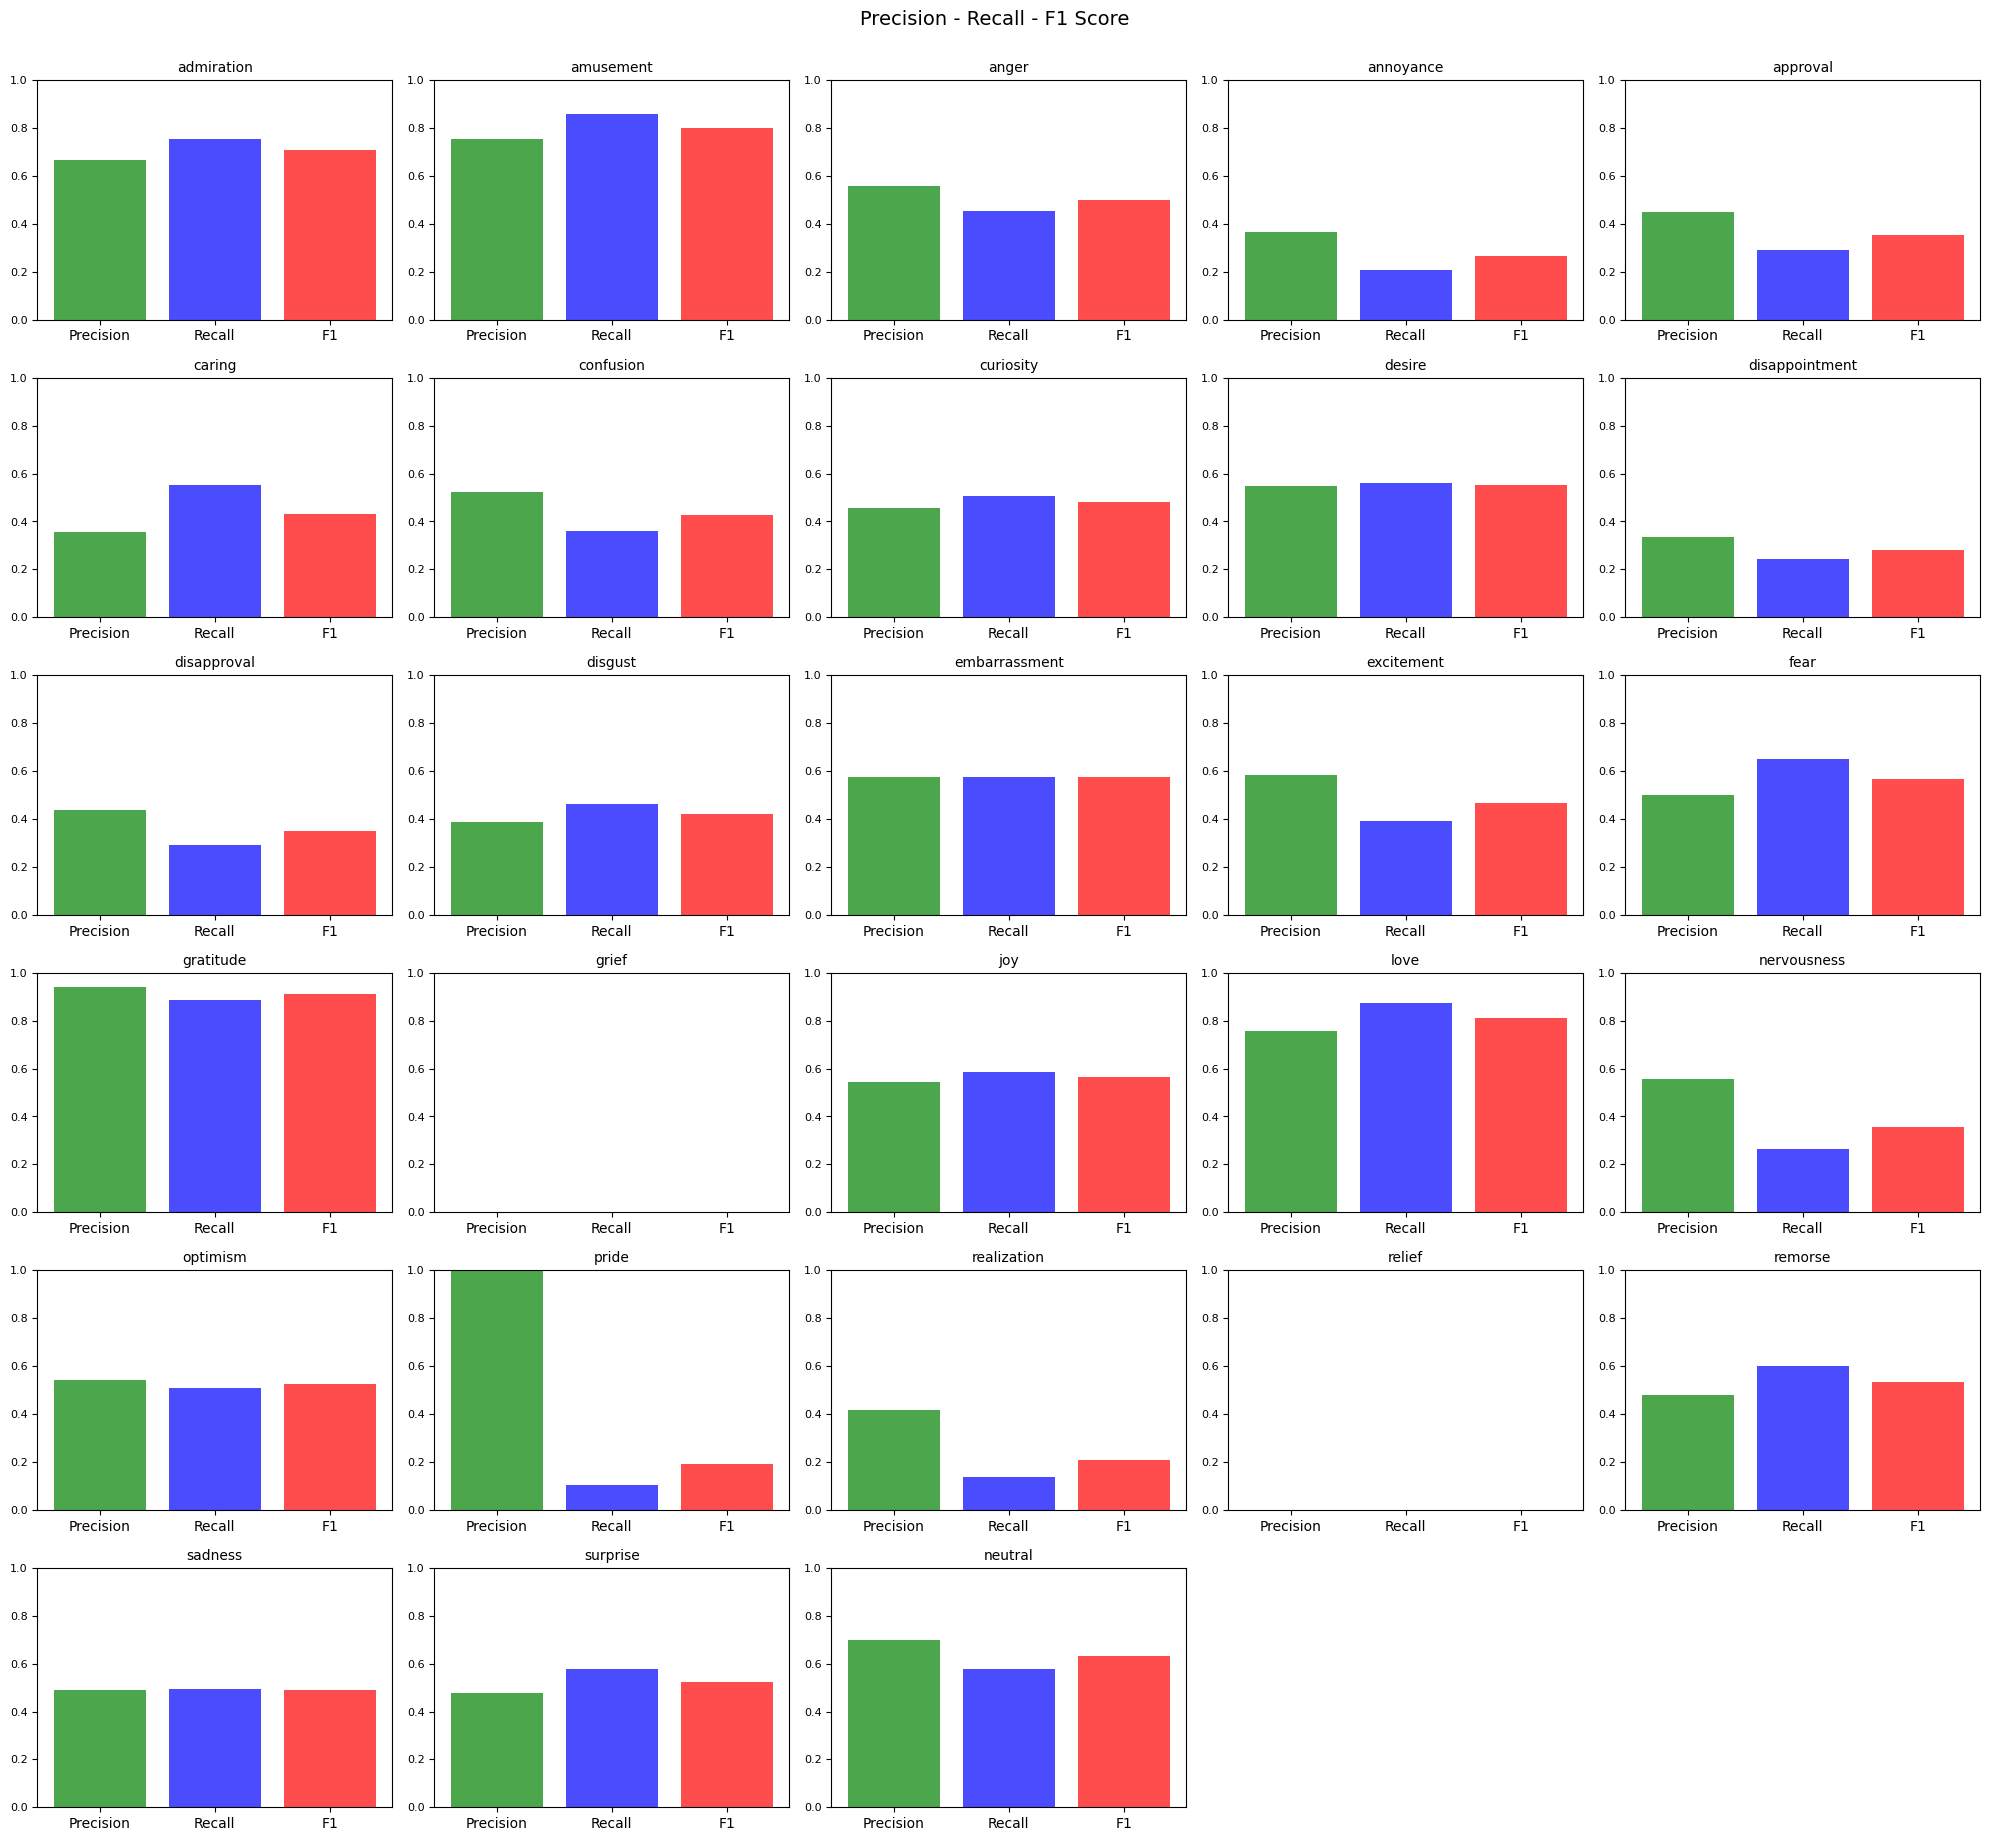

In [39]:
precisions, recalls, f1s, supports = precision_recall_fscore_support(all_labels, all_preds, average=None)

labels = [model.config.id2label[i] for i in range(len(precisions))]

df_metrics = pd.DataFrame({
    'label': labels,
    'precision': precisions,
    'recall': recalls,
    'f1': f1s,
    'support': supports
})

n_labels = len(df_metrics)
cols = 5  
rows = (n_labels + cols - 1) // cols  

fig, axs = plt.subplots(rows, cols, figsize=(cols * 4, rows * 3))
axs = axs.flatten()  

colors = ['green', 'blue', 'red']  

for i, row in enumerate(df_metrics.itertuples()):
    ax = axs[i]
    ax.bar(['Precision', 'Recall', 'F1'], [row.precision, row.recall, row.f1], color=colors, alpha=0.7)
    ax.set_ylim(0, 1)
    ax.set_title(row.label, fontsize=10)
    ax.set_xticks([0, 1, 2])
    ax.tick_params(axis='x', rotation=0)
    ax.tick_params(axis='y', labelsize=8)

for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.suptitle("Precision - Recall - F1 Score", fontsize=14, y=1.02)
plt.show()

In [40]:
df_metrics

,label,precision,recall,f1,support
0,admiration,0.668821,0.756856,0.710120,547
1,amusement,0.753247,0.859259,0.802768,270
2,anger,0.557692,0.453125,0.500000,192
3,annoyance,0.368421,0.207237,0.265263,304
4,approval,0.449580,0.290761,0.353135,368
5,caring,0.354260,0.552448,0.431694,143
6,confusion,0.521277,0.360294,0.426087,136
7,curiosity,0.457143,0.507937,0.481203,252
8,desire,0.546512,0.559524,0.552941,84
9,disappointment,0.333333,0.243421,0.281369,152


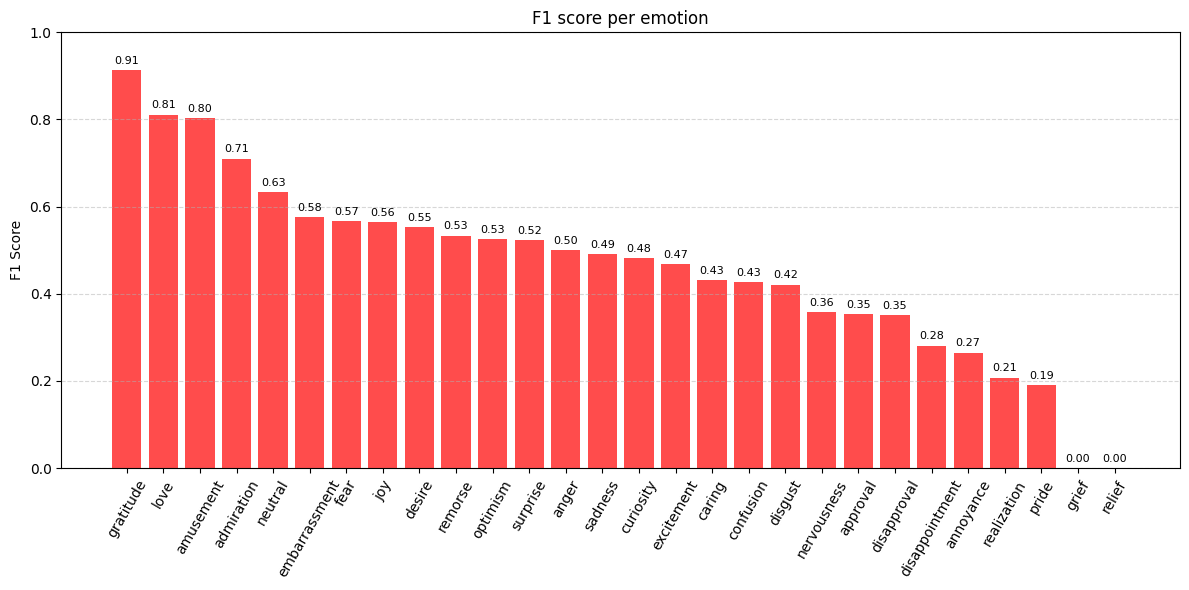

In [41]:
sorted_f1 = df_metrics.sort_values(by='f1', ascending=False)

plt.figure(figsize=(12, 6))
bars = plt.bar(sorted_f1['label'], sorted_f1['f1'], color='red', alpha=0.7)

plt.xticks(rotation=60, ha='center')
plt.ylabel("F1 Score")
plt.title("F1 score per emotion")
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.5)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01, f"{height:.2f}",
             ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()


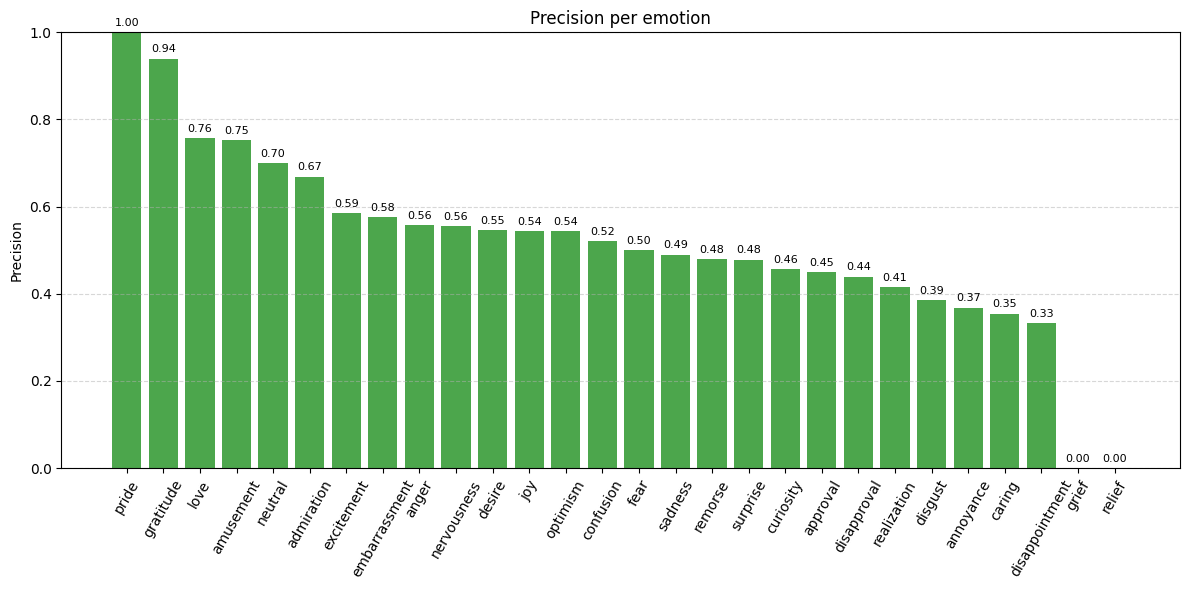

In [42]:
sorted_precision = df_metrics.sort_values(by='precision', ascending=False)

plt.figure(figsize=(12, 6))
bars = plt.bar(sorted_precision['label'], sorted_precision['precision'], color='green', alpha=0.7)

plt.xticks(rotation=60, ha='center')
plt.ylabel("Precision")
plt.title("Precision per emotion")
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.5)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01, f"{height:.2f}",
             ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

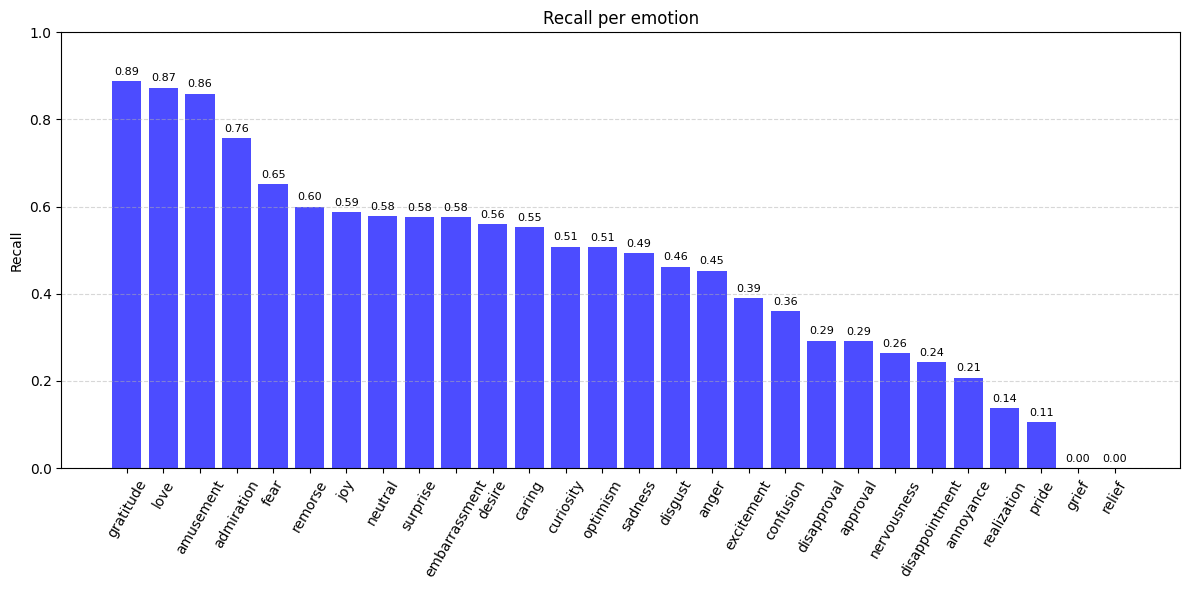

In [43]:
sorted_recall = df_metrics.sort_values(by='recall', ascending=False)

plt.figure(figsize=(12, 6))
bars = plt.bar(sorted_recall['label'], sorted_recall['recall'], color='blue', alpha=0.7)

plt.xticks(rotation=60, ha='center')
plt.ylabel("Recall")
plt.title("Recall per emotion")
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.5)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01, f"{height:.2f}",
             ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

/tmp/ipykernel_1859/1565270786.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(df['label'], rotation=60, ha='center')


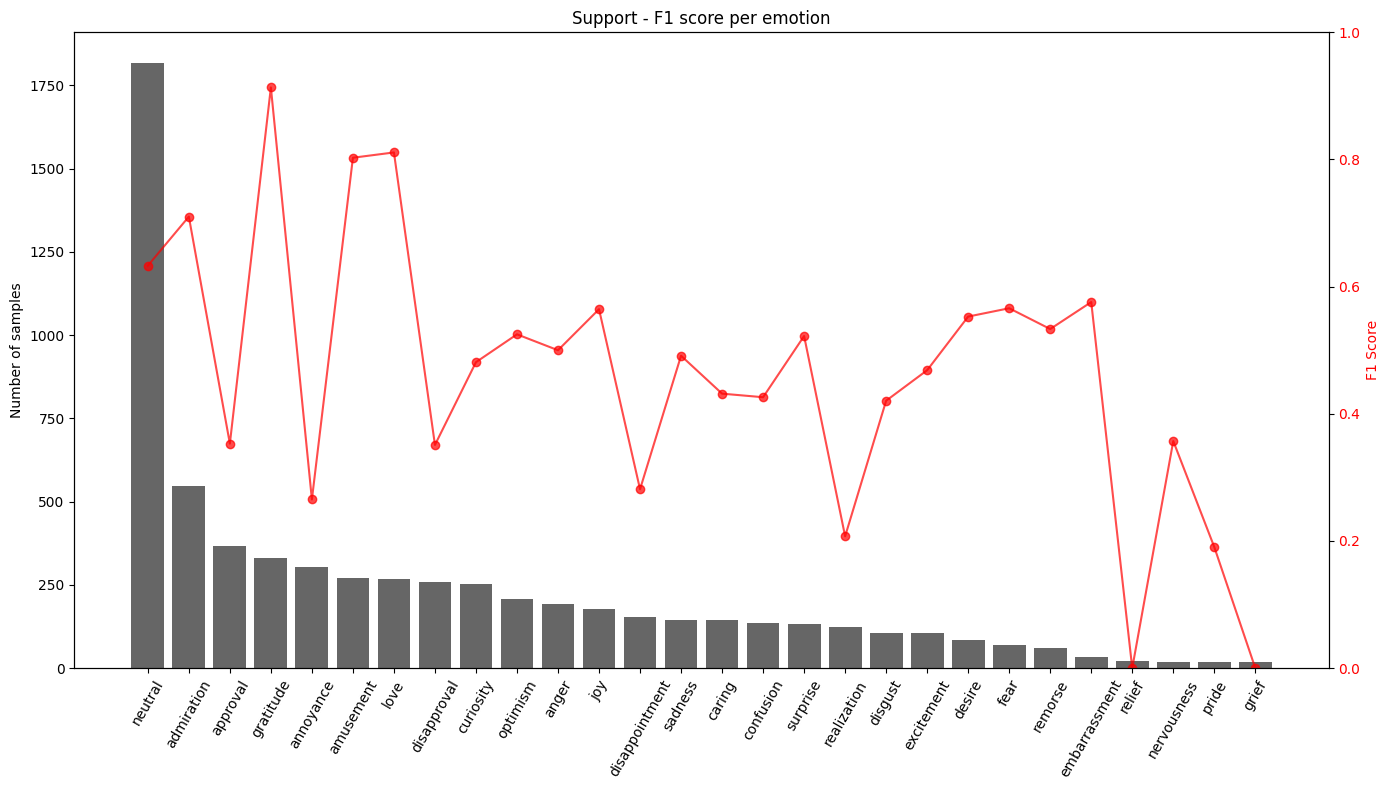

In [44]:
df = df_metrics.sort_values(by='support', ascending=False)

fig, ax1 = plt.subplots(figsize=(14, 8))

color_support = 'black'
ax1.bar(df['label'], df['support'], color=color_support, label='Support (test)', alpha=0.6)
ax1.set_ylabel('Number of samples', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.set_xticklabels(df['label'], rotation=60, ha='center')

ax2 = ax1.twinx()
ax2.plot(df['label'], df['f1'], color='red', marker='o', label='F1 Score', alpha=0.7)
ax2.set_ylabel('F1 Score', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.set_ylim(0, 1)

plt.title("Support - F1 score per emotion")
fig.tight_layout()
plt.show()

/tmp/ipykernel_1859/28799819.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(df['label'], rotation=60, ha='center')


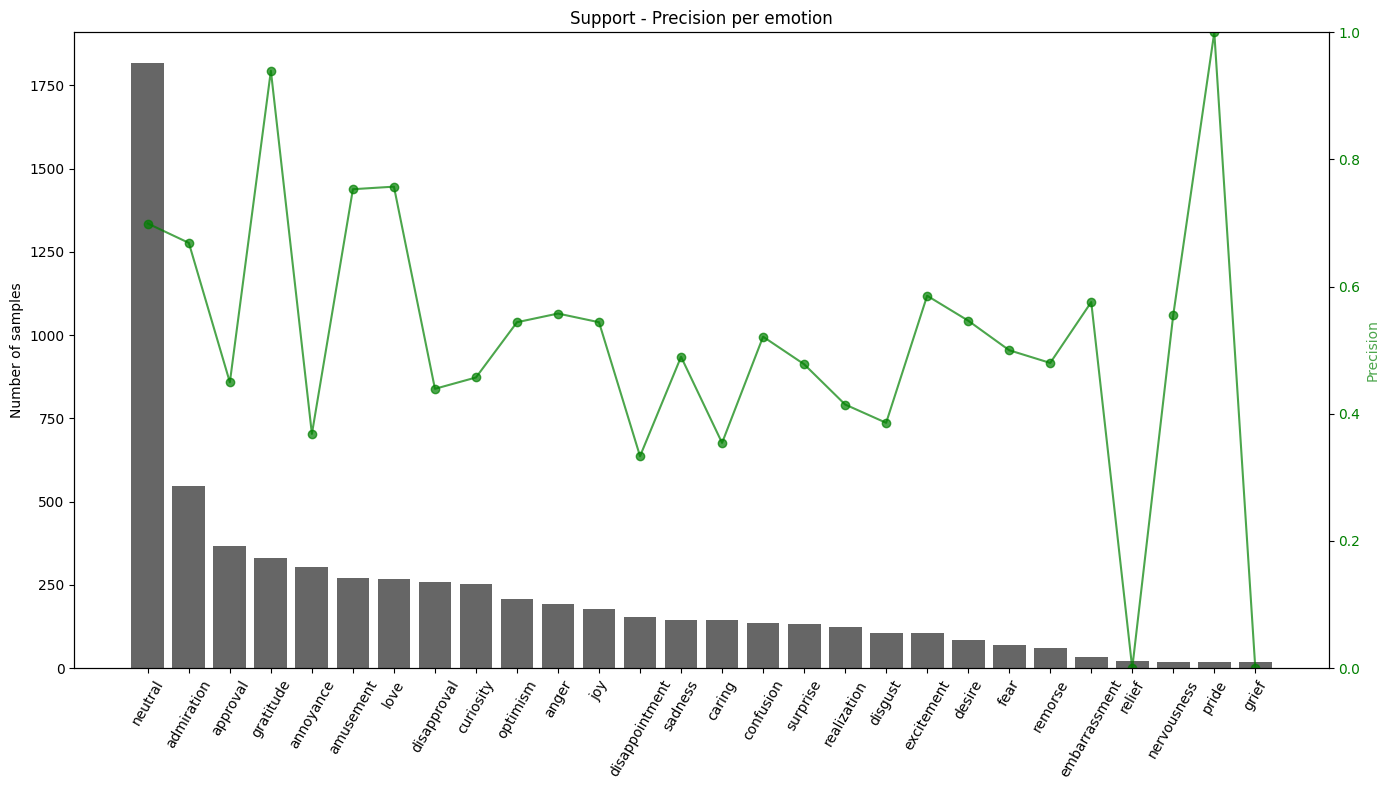

In [45]:
fig, ax1 = plt.subplots(figsize=(14, 8))

color_support = 'black'
ax1.bar(df['label'], df['support'], color=color_support, label='Support (test)', alpha=0.6)
ax1.set_ylabel('Number of samples', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.set_xticklabels(df['label'], rotation=60, ha='center')

ax2 = ax1.twinx()
ax2.plot(df['label'], df['precision'], color='green', marker='o', label='Precision', alpha=0.7)
ax2.set_ylabel('Precision', color='green', alpha=0.7)
ax2.tick_params(axis='y', labelcolor='green')
ax2.set_ylim(0, 1)

plt.title("Support - Precision per emotion")
fig.tight_layout()
plt.show()

/tmp/ipykernel_1859/2518018146.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(df['label'], rotation=60, ha='center')


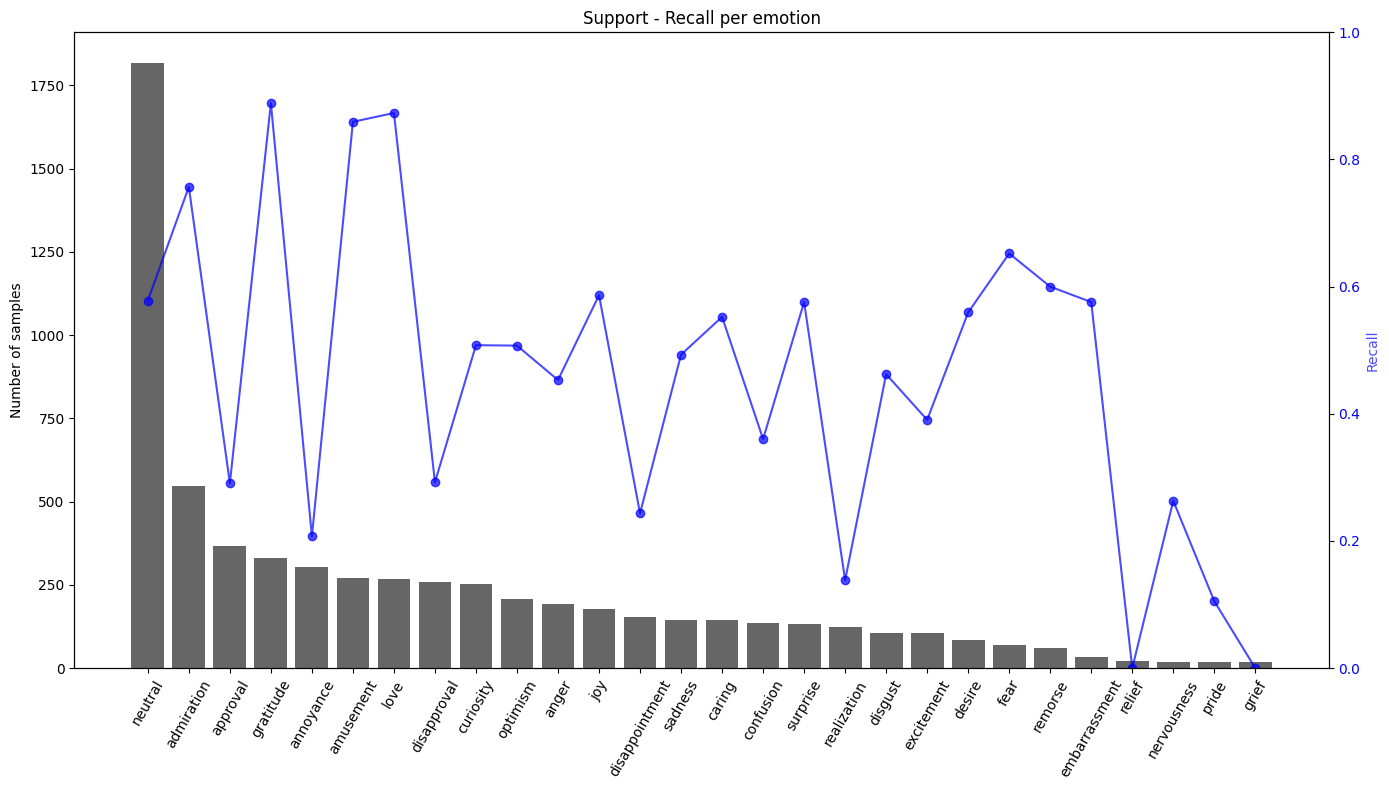

In [46]:
fig, ax1 = plt.subplots(figsize=(14, 8))

color_support = 'black'
ax1.bar(df['label'], df['support'], color=color_support, label='Support (test)', alpha=0.6)
ax1.set_ylabel('Number of samples', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.set_xticklabels(df['label'], rotation=60, ha='center')

ax2 = ax1.twinx()
ax2.plot(df['label'], df['recall'], color='blue', marker='o', label='Recall', alpha=0.7)
ax2.set_ylabel('Recall', color='blue', alpha=0.7)
ax2.tick_params(axis='y', labelcolor='blue')
ax2.set_ylim(0, 1)

plt.title("Support - Recall per emotion")
fig.tight_layout()
plt.show()

### Explainability

In [47]:
preds_df = pd.DataFrame(all_preds, columns=emotions)
results = pd.concat([X_test.reset_index(drop=True), preds_df], axis=1)

In [48]:
def get_predicted_labels(row):
    return [label for label, val in row.items() if val == 1]

results['predicted_labels'] = results[emotions].apply(get_predicted_labels, axis=1)

In [49]:
results

,text,id,author,subreddit,created_utc,admiration,amusement,anger,annoyance,approval,...,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral,predicted_labels
0,Whoa this is really creepy,ee05ddd,Di-Vanci,morbidquestions,2019-01-13,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,[fear]
1,"Ok, I will take this with a pinch of salt, but...",ef43ust,EloCross,relationships,2019-01-27,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,[gratitude]
2,"I love bloodborne, I started my second play th...",ediu7qx,THE-EMPEROR069,dating,2019-01-08,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,[love]
3,"Oh my goodness, I'm so glad you were there too...",ede1w2h,shadedferns,TalesFromRetail,2019-01-06,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,[joy]
4,Yeah -- a woman who expects a guy to never eve...,efgxbk9,reluctantly_red,PurplePillDebate,2019-01-31,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,[neutral]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5422,De nada!,eelqsur,PuddleOfJelm,NoFap,2019-01-21,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,[neutral]
5423,"Great job, now let's get two points.",ee94idc,Sabres8127,sabres,2019-01-17,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,[admiration]
5424,RemindMe!,efe1coq,marymess,relationship_advice,2019-01-30,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,[neutral]
5425,i love all harper news because i love the shit...,ed3uc1g,robindodge,Dodgers,2019-01-02,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,[love]


#### SHAP

In [50]:
import shap
from transformers import TextClassificationPipeline

In [51]:
tokenizer = AutoTokenizer.from_pretrained("roberta-base")
model_fine = AutoModelForSequenceClassification.from_pretrained(save_path)

In [52]:
pipe = TextClassificationPipeline(
    model=model,
    tokenizer=tokenizer,
    return_all_scores=True,  
    function_to_apply='sigmoid',  
    device=0 if torch.cuda.is_available() else -1
)

Device set to use cuda:0
/home/biso/Uni/corsi/uni_venv/lib/python3.11/site-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [53]:
model.eval()
explainer = shap.Explainer(pipe, tokenizer)

In [54]:
def predict(sentence):
    enc = tokenizer(sentence, 
                    padding='max_length',
                    max_length=128,
                    return_tensors='pt').to(device)
    
    with torch.no_grad():
        outputs = model(**enc, output_hidden_states=True)
        logits = outputs.logits
        probs = torch.sigmoid(logits)
        hiddens = outputs.hidden_states

    print(f"\nLogits: {logits.cpu().numpy()}")
    print(f"\nProbs: {probs.cpu().numpy()}")

    preds = (probs > 0.5).int()

    if preds.sum() == 0:
        top_idx = torch.argmax(probs).item()
        preds[0, top_idx] = 1

    pred_labels = [model.config.id2label[i] for i in range(preds.size(1)) if preds[0, i] == 1]

    print(f"\nLabel prediction: {pred_labels}")
    return pred_labels

def local_exp_shap(explainer, sentence):
    shap_values = explainer([sentence])
    tokens = shap_values.data[0]

    shap_matrix = shap_values.values[0] # shape: (n_tokens, n_emotions)
    
    df_shap = pd.DataFrame(
        shap_matrix, 
        index=tokens,
        columns=emotions
    )

    return df_shap

def plot_exp(df_top, label):
    colors = ['green' if val > 0 else 'red' for val in df_top.values]

    plt.figure(figsize=(10, 6))
    plt.barh(df_top.index, df_top.values, color=colors)
    plt.xlabel('SHAP Value')
    plt.title(f'Token Influence on Emotion: {label}')
    plt.gca().invert_yaxis()  
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.show()

def local_explainability(text_example):
    pred_labels = predict(text_example)
    local_exp = local_exp_shap(explainer, text_example)
    for l in pred_labels:
        df = local_exp[l].sort_values(ascending=False)
        plot_exp(df, l)


Logits: [[-3.8261263  2.109497  -6.381496  -5.4220614 -4.5089436 -5.526006
  -6.375343  -6.20576   -6.3630533 -6.357803  -5.5309815 -6.629033
  -6.7174554 -4.209402  -7.0080895 -3.155502  -7.391839  -0.609571
  -5.169049  -7.3577824 -4.6673946 -7.210885  -4.7490406 -5.546574
  -6.440706  -5.6399593 -5.5423565 -4.6009   ]]

Probs: [[2.1329032e-02 8.9182287e-01 1.6897290e-03 4.3985965e-03 1.0890183e-02
  3.9660675e-03 1.7001404e-03 2.0137115e-03 1.7211270e-03 1.7301717e-03
  3.9464617e-03 1.3196963e-03 1.2081510e-03 1.4637800e-02 9.0371759e-04
  4.0875029e-02 6.1588205e-04 3.5215706e-01 5.6577865e-03 6.3720456e-04
  9.3092434e-03 7.3795824e-04 8.5856477e-03 3.8856410e-03 1.5927395e-03
  3.5404337e-03 3.9019994e-03 9.9429367e-03]]

Label prediction: ['amusement']


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


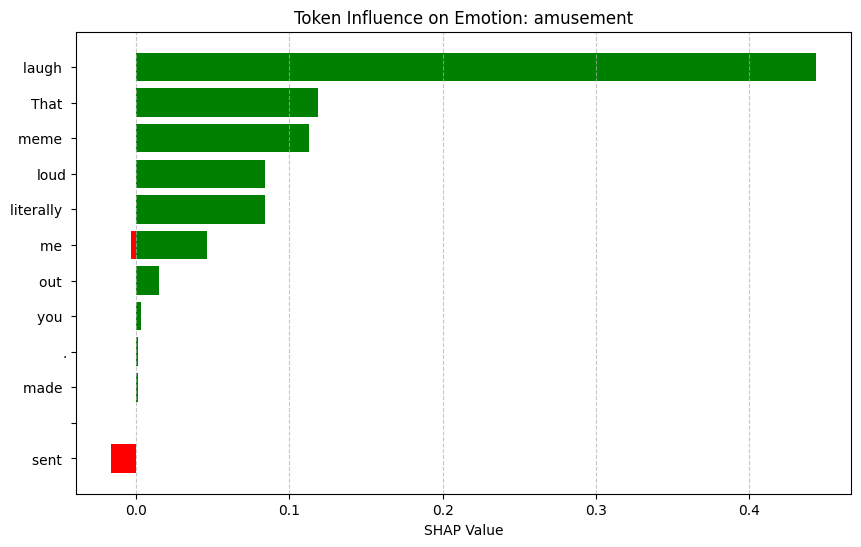

In [55]:
text_example = "That meme you sent me literally made me laugh out loud." # made with chatGPT

local_explainability(text_example)

The token "laugh" gives a strong contribution to the prediction of the label Amusement.


Logits: [[-6.574594  -6.702948  -7.3326993 -5.683568  -1.419313  -6.9784923
  -6.5551305 -5.8839407 -5.846171  -6.374057  -6.145308  -6.606626
  -7.8806314 -5.5171013 -7.9954686 -7.3817286 -9.117973  -6.192248
  -6.654482  -8.548714  -4.1328735 -7.7992444 -4.627579  -7.3033667
  -8.16266   -7.6017613 -7.7385354  1.6449373]]

Probs: [[1.3934280e-03 1.2257841e-03 6.5337919e-04 3.3898700e-03 1.9476932e-01
  9.3083957e-04 1.4207758e-03 2.7760656e-03 2.8826140e-03 1.7023245e-03
  2.1389306e-03 1.3495602e-03 3.7785148e-04 4.0014009e-03 3.3687265e-04
  6.2213658e-04 1.0966470e-04 2.0410498e-03 1.2865780e-03 1.9375667e-04
  1.5783614e-02 4.0987664e-04 9.6837105e-03 6.7281531e-04 2.8502184e-04
  4.9932132e-04 4.3551950e-04 8.3820564e-01]]

Label prediction: ['neutral']


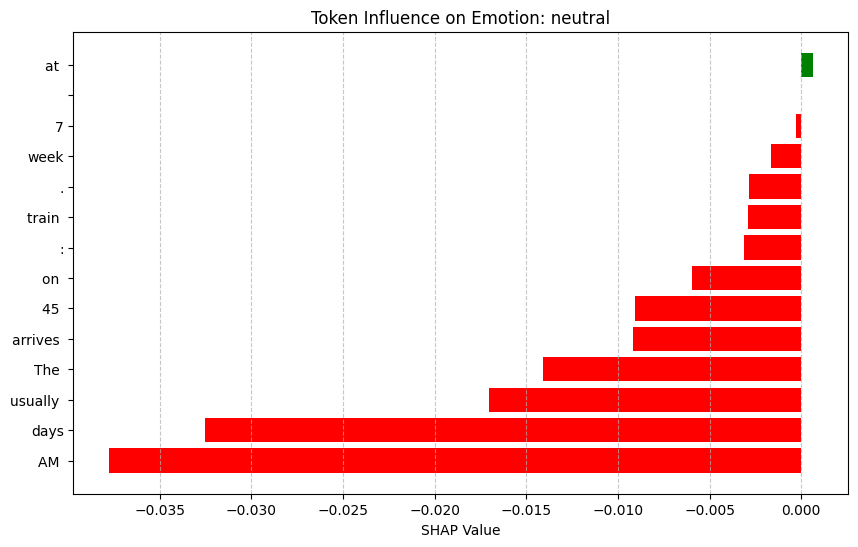

In [56]:
text_example = "The train usually arrives at 7:45 AM on weekdays."
local_explainability(text_example)


Logits: [[-5.357548  -7.4885125 -7.6192393 -6.266862  -2.2414615 -6.3762584
  -6.1666155 -6.0309286 -6.6894865 -6.669881  -5.8829875 -7.2016516
  -8.613033  -6.6734805 -8.042167  -6.8162093 -8.795951  -6.8526964
  -6.978767  -8.581416  -5.020036  -7.915694  -4.850615  -7.49476
  -8.332091  -7.697534  -7.616405   2.668542 ]]

Probs: [[4.6903426e-03 5.5916171e-04 4.9067423e-04 1.8945795e-03 9.6088529e-02
  1.6985872e-03 2.0939321e-03 2.3974993e-03 1.2423760e-03 1.2669427e-03
  2.7787054e-03 7.4479863e-04 1.8168884e-04 1.2623961e-03 3.2150798e-04
  1.0946675e-03 1.5132174e-04 1.0554875e-03 9.3058421e-04 1.8752401e-04
  6.5609566e-03 3.6483727e-04 7.7628316e-03 5.5568118e-04 2.4061030e-04
  4.5373919e-04 4.9206626e-04 9.3514472e-01]]

Label prediction: ['neutral']


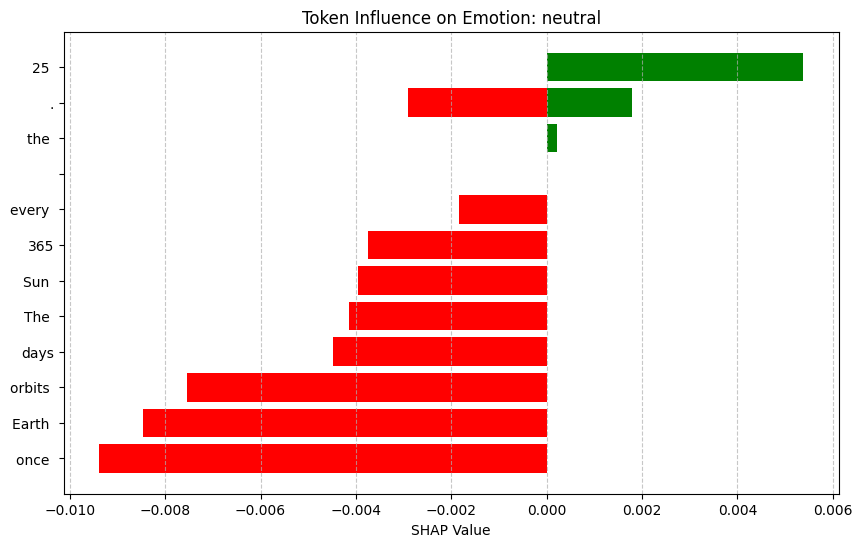

In [57]:
text_example = "The Earth orbits the Sun once every 365.25 days."
local_explainability(text_example)


Logits: [[-7.076892   -6.0825124  -4.25809    -1.6303055  -5.2870636  -6.385475
  -1.2483748  -1.1925476  -6.4930983  -0.73874867 -4.7333117  -4.1402206
  -2.6130621  -5.8742814  -5.22194    -7.2612596  -6.6453233  -5.747834
  -6.355517   -4.3556046  -5.149432   -6.7608347  -3.4957814  -6.6605372
  -4.993034   -3.4965796  -3.6318848  -2.3150573 ]]

Probs: [[0.00084368 0.00227724 0.01395189 0.16378851 0.00503115 0.00168303
  0.22298157 0.23280364 0.00151156 0.32327783 0.00872057 0.01566989
  0.06830247 0.00280293 0.00536788 0.00070173 0.0012984  0.00317954
  0.00173412 0.01267204 0.00576922 0.00115692 0.0294325  0.00127882
  0.00673932 0.02940971 0.02578385 0.08988358]]

Label prediction: ['disappointment']


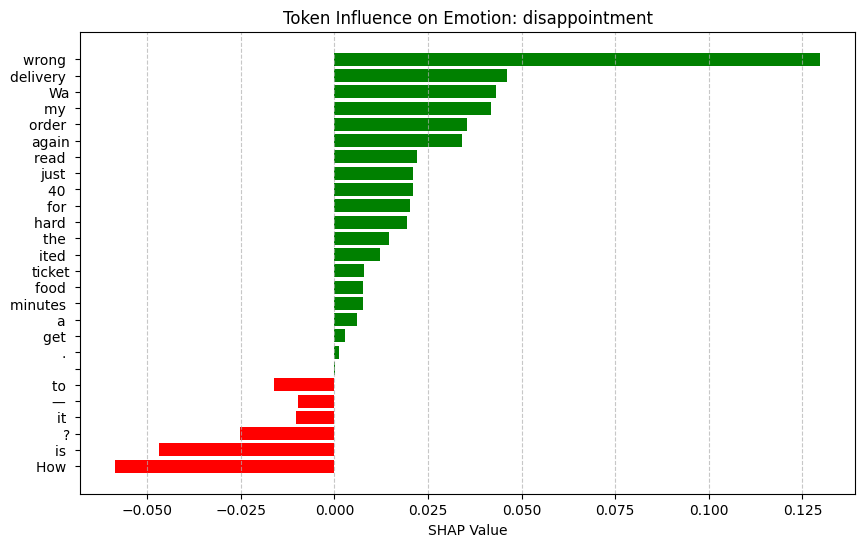

In [58]:
text_example = "Waited 40 minutes for my food delivery just to get the wrong order — again. How hard is it to read a ticket?"
local_explainability(text_example)


Logits: [[-6.294637  -6.572724   0.8764892 -1.2344812 -5.287334  -5.753423
  -6.782882  -6.1702614 -5.758219  -3.91863   -3.9785233 -1.6781207
  -5.902408  -7.5930266 -6.0006375 -6.7073874 -7.232311  -7.0731826
  -6.6697326 -7.1927376 -5.0784454 -7.3499565 -5.882575  -8.163046
  -6.996101  -4.750135  -6.4444633 -1.9962255]]

Probs: [[1.8427769e-03 1.3960326e-03 7.0609421e-01 2.2539808e-01 5.0297929e-03
  3.1618751e-03 1.1317225e-03 2.0863276e-03 3.1467958e-03 1.9481238e-02
  1.8369501e-02 1.5734448e-01 2.7254075e-03 5.0369959e-04 2.4710512e-03
  1.2203611e-03 7.2232640e-04 8.4681372e-04 1.2671304e-03 7.5146247e-04
  6.1910180e-03 6.4220757e-04 2.7798486e-03 2.8491180e-04 9.1460714e-04
  8.5763382e-03 1.5867755e-03 1.1959980e-01]]

Label prediction: ['anger']


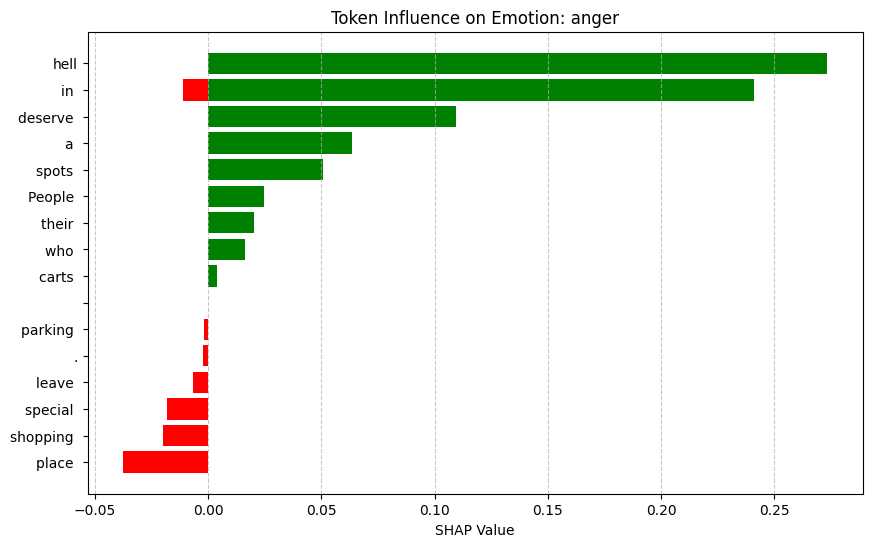

In [59]:
text_example = "People who leave their shopping carts in parking spots deserve a special place in hell."
local_explainability(text_example)

#### Global explainability

In [60]:
from collections import defaultdict
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [61]:
def global_exp_shap_full(explainer, texts, emotions, save_path="global_shap.csv"):
    shap_values = explainer(texts)
    
    token_shap_agg = defaultdict(list)
    
    for i in range(len(texts)):  
        tokens = shap_values.data[i]  
        shap_vals = shap_values.values[i]  # Shape: (n_tokens, n_emotions)
        
        for token_idx, token in enumerate(tokens):
            for emotion_idx in range(len(emotions)):
                key = (token, emotions[emotion_idx])
                token_shap_agg[key].append(shap_vals[token_idx, emotion_idx])
    
    agg_results = []
    for (token, emotion), shap_list in token_shap_agg.items():
        avg_shap = np.mean(shap_list)  
        agg_results.append({'token': token, 'emotion': emotion, 'avg_shap_value': avg_shap})

    df_global_shap = pd.DataFrame(agg_results)
    
    df_global = df_global_shap.pivot(index='token', columns='emotion', values='avg_shap_value')
    
    df_global.to_csv(save_path)
    
    return df_global

In [ ]:
texts = results['text'].sample(500, random_state=42).tolist()
df_global_shap = global_exp_shap_full(
    explainer,
    texts,
    emotions,
    save_path="data/global_shap.csv"  
)

In [63]:
global_exp = pd.read_csv("../data/global_shap.csv")
global_exp

,token,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,desire,...,love,nervousness,neutral,optimism,pride,realization,relief,remorse,sadness,surprise
0,NaN,7.685687e-07,0.000007,0.000008,0.000018,0.000078,0.000036,0.000023,-0.000005,0.000006,...,0.000011,0.000004,-0.000353,0.000039,0.000005,0.000038,0.000002,0.000010,0.000037,0.000017
1,!,6.739146e-03,0.003391,0.000613,0.001767,0.016018,-0.000464,-0.000639,0.002800,0.001945,...,0.001484,0.000179,-0.097546,0.003498,0.000502,0.001172,0.000713,-0.000005,-0.000155,0.002816
2,!,6.310213e-03,0.003040,0.002017,0.005339,0.019487,-0.001048,-0.001944,0.006432,0.003662,...,0.002140,0.000237,-0.105380,0.002628,0.000456,0.000861,0.000443,0.000004,0.000011,0.001366
3,!!,1.316151e-02,0.005387,0.004222,0.002035,0.031619,-0.001609,-0.000375,0.000544,0.001518,...,0.001777,0.000411,-0.150010,-0.000302,0.010083,-0.000023,0.000620,0.000045,-0.000032,0.001546
4,!!,2.096502e-02,0.007301,0.001581,-0.000346,0.023813,0.000402,-0.001278,0.002394,0.002055,...,0.012365,0.000206,-0.164232,0.000934,0.000909,0.001535,0.000572,0.000112,-0.000151,0.031218
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2625,😭,2.106412e-02,0.051384,0.000525,0.005806,0.012004,0.000221,0.001387,0.001130,0.001304,...,0.010150,0.000839,-0.076602,0.003898,0.000224,0.028642,0.000088,0.000746,0.005282,-0.031905
2626,🙄,6.107883e-05,0.005688,0.001120,0.003956,0.030894,0.000986,0.001004,0.001324,0.000119,...,0.000666,0.000025,-0.051973,0.001062,0.000024,-0.000128,0.000061,-0.000002,0.000168,-0.000071
2627,🙏,1.063852e-05,0.000766,0.000049,0.000092,0.004911,0.000229,0.000308,0.000501,0.000055,...,0.000809,0.000016,-0.006464,0.000789,0.000003,0.000092,0.000023,0.000003,0.000030,-0.000004
2628,🤲,-1.929750e-04,0.001184,-0.000103,-0.000320,0.000257,-0.000038,0.004057,0.000974,-0.000033,...,0.000599,0.000015,0.002267,0.000171,-0.000012,0.000529,0.000005,0.000019,0.000031,0.000007


In [64]:
# sorted by "admiration"
global_exp.sort_values(by='admiration', ascending=False).head(10)

,token,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,desire,...,love,nervousness,neutral,optimism,pride,realization,relief,remorse,sadness,surprise
716,awesome,0.931179,-0.012891,-0.002260,-0.007091,-0.007653,-0.000879,-0.015904,-0.062641,-0.002286,...,0.003042,-0.000264,-0.656809,0.000541,0.000900,-0.001129,-0.000756,0.000360,0.000194,0.002549
369,Nice,0.920743,-0.000651,0.000304,-0.001594,0.005306,-0.001113,-0.055013,-0.113103,-0.001891,...,0.002986,0.000239,-0.641210,0.001243,0.001775,-0.000409,-0.000011,0.000861,0.000319,0.000750
751,beautiful,0.880888,-0.175752,-0.000842,-0.009279,-0.013429,0.001187,-0.001697,-0.000362,-0.000920,...,0.019539,-0.000708,-0.191020,0.000264,0.002296,-0.089396,-0.000109,-0.000219,0.000298,-0.146149
1761,nice,0.861150,-0.001356,-0.014253,-0.112589,-0.050372,-0.014978,-0.000430,-0.000621,-0.000733,...,0.003473,-0.001062,-0.519473,-0.001814,0.001461,-0.001526,-0.000073,0.000337,-0.000870,-0.001194
966,cute,0.809294,-0.000248,-0.000034,-0.007299,-0.000031,0.002021,-0.047108,-0.102102,0.000507,...,0.014339,0.000240,-0.486008,0.003728,0.001616,-0.002406,-0.000053,0.000866,0.001078,-0.003937
370,Nice,0.763734,-0.000972,-0.000061,-0.003260,-0.054380,-0.002096,-0.025777,-0.015016,-0.000639,...,0.001945,0.000141,-0.552953,-0.064131,0.001114,-0.001029,-0.000158,0.000644,0.000727,0.000492
1887,perfect,0.752036,-0.000179,-0.000682,-0.017367,0.009176,0.001725,-0.001634,-0.000459,-0.000516,...,0.002961,-0.001525,-0.654520,0.004494,0.001120,-0.008426,0.000151,0.000060,-0.000977,-0.018586
1473,incredible,0.720296,-0.000121,-0.000740,-0.004121,-0.020671,0.001063,-0.021708,-0.075675,-0.000266,...,0.000001,0.000194,-0.529394,0.000981,0.000991,-0.001012,-0.000016,0.000442,0.000872,0.002944
642,amazing,0.688655,0.006561,0.000052,0.003367,-0.052488,-0.000553,0.005095,0.004518,0.000066,...,-0.004342,0.000826,-0.594552,0.001652,0.001622,-0.000711,0.000078,0.000169,-0.019416,0.035721
1162,expert,0.677772,-0.000947,-0.009462,-0.031800,0.021506,-0.002892,-0.000389,-0.000705,-0.000090,...,0.000337,-0.000103,-0.622416,0.004384,0.002156,-0.000866,0.000220,0.000203,-0.000260,0.000322


In [65]:
# sorted by "anger"
global_exp.sort_values(by='anger', ascending=False).head(10)

,token,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,desire,...,love,nervousness,neutral,optimism,pride,realization,relief,remorse,sadness,surprise
240,Fuck,0.000647,0.005209,0.862752,0.106574,-0.001325,0.002664,-0.000624,-0.001331,0.000293,...,0.004866,0.000287,-0.926252,0.000128,0.000132,-0.000228,-0.000156,0.000661,0.002900,0.007091
1258,fucking,0.068873,0.006695,0.604053,0.190304,-0.014596,-0.001808,-0.006967,-0.022279,-0.000197,...,0.004697,0.000175,-0.684772,-0.001826,0.000358,-0.001130,-0.000077,0.000124,0.001021,0.011059
1256,fuck,-0.005208,0.001847,0.547846,0.305865,-0.007974,-0.000481,0.000689,0.000564,-0.001109,...,0.000372,-0.000033,-0.783950,-0.001710,-0.000368,-0.000797,-0.000619,-0.000049,-0.004823,0.003218
975,dare,-0.005076,0.006192,0.428062,0.057106,-0.045735,0.005683,-0.045551,-0.213046,0.010014,...,0.001315,0.000235,-0.234483,0.001813,-0.000027,-0.002115,-0.000164,0.000442,0.001351,0.000328
1588,liar,-0.239233,-0.115841,0.334620,0.159533,-0.053942,0.001016,-0.000720,-0.004251,-0.004439,...,-0.022274,0.000386,-0.099092,-0.014357,-0.000525,-0.003081,-0.000339,0.002385,0.008239,-0.000491
1257,fuck,-0.000073,0.007986,0.323716,0.335309,-0.004718,-0.001648,-0.001416,-0.000745,-0.004236,...,-0.000675,0.000179,-0.744365,-0.004007,-0.000095,-0.012544,-0.002540,-0.000152,0.012539,0.013059
1905,pissed,-0.041375,0.001408,0.298055,0.125507,-0.027702,-0.004574,-0.000216,0.000161,0.000294,...,0.001053,0.000358,-0.255159,-0.007501,0.004450,-0.001499,-0.000281,0.000685,0.002625,0.000619
1363,hate,-0.020361,0.000427,0.272786,0.063601,0.010410,0.000378,0.000747,-0.000232,-0.001884,...,-0.001430,0.000084,-0.261794,-0.000750,-0.000075,-0.000078,-0.000309,0.000278,0.002432,0.000468
187,Damn,0.004348,0.005184,0.247639,0.541402,-0.006342,0.001482,0.000215,0.000813,0.000088,...,-0.000058,0.001559,-0.595048,-0.003136,0.000832,0.003515,0.000047,0.000103,0.005106,0.009010
462,TF,-0.013462,-0.000487,0.241313,0.268218,-0.036681,0.000219,0.009059,0.012604,-0.001316,...,-0.007981,0.000413,-0.356162,-0.000611,-0.000934,0.005354,-0.000940,0.000163,0.000500,0.061168


In [66]:
def heatmap_top10_tokens(heatmap_matrix):
    plt.figure(figsize=(20, 9))

    ax = sns.heatmap(
        heatmap_matrix, 
        vmin=-1, vmax=1,  
        cmap='coolwarm',  
        annot=tokens,  
        fmt='',  
        cbar_kws={'label': 'SHAP Value'}
    )

    # Labels
    ax.set_yticks(np.arange(len(emotions)) + 0.5)
    ax.set_yticklabels(emotions, rotation=0)

    ax.set_xticks(np.arange(10) + 0.5)
    ax.set_xticklabels([str(i) for i in range(1, 11)])

    plt.xlabel('Word Rank')
    plt.ylabel('Emotion')

    plt.tight_layout()
    plt.show()

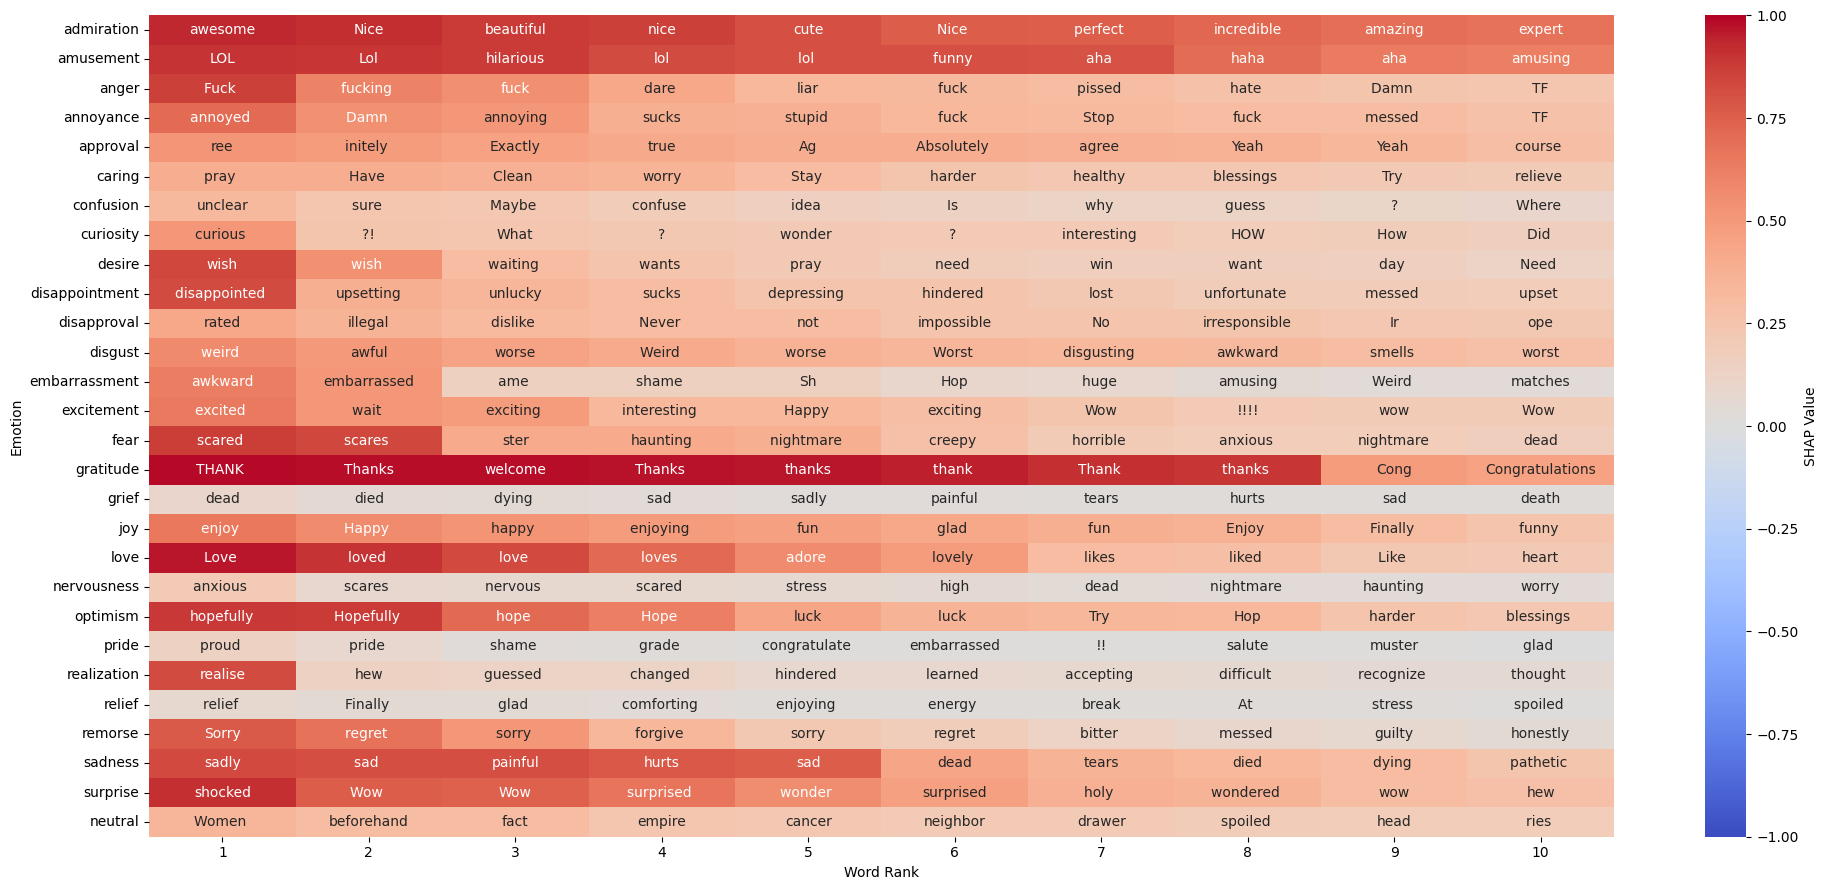

In [67]:
heatmap_data = []
tokens = []

for emotion in emotions:
    top_tokens = global_exp[['token', emotion]].sort_values(by=emotion, ascending=False).head(10)
    heatmap_data.append(top_tokens[emotion].values)
    tokens.append(top_tokens['token'].values)

heatmap_matrix = np.array(heatmap_data)
tokens_matrix = np.array(tokens)

heatmap_top10_tokens(heatmap_matrix)

#### Embeddings (Pre vs Post fine tuning)

In [68]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
import plotly.express as px
from sklearn.metrics.pairwise import cosine_similarity

In [69]:
tokenizer = AutoTokenizer.from_pretrained("roberta-base")
model_pre  = AutoModelForSequenceClassification.from_pretrained("roberta-base").to(device)
model_fine = AutoModelForSequenceClassification.from_pretrained(save_path).to(device)

model_pre.config.output_hidden_states  = True
model_pre.eval()

model_fine.config.output_hidden_states = True
model_fine.eval()

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [81]:
# Estrazione dell'embedding della frase intera (media dei token)
def get_sentence_embedding(text, tokenizer, model):
    inputs = tokenizer(text, return_tensors='pt', truncation=True).to(model.device)
    with torch.no_grad():
        outputs = model(**inputs, output_hidden_states=True)
    hidden_states = outputs.hidden_states[-1]  # ultimo layer
    sentence_embedding = hidden_states.mean(dim=1).squeeze()  # media dei token
    return sentence_embedding.cpu().numpy()

In [ ]:
words = ["happy", "sad", "angry", "joy", "fear", "love", "hate", "surprise", "disgust"]

embeddings_pre = [get_sentence_embedding(word, tokenizer, model_pre) for word in words]
embeddings_fine = [get_sentence_embedding(word, tokenizer, model_fine) for word in words]

Length embeddings (pre fine-tuning): 768
Length embeddings (post fine-tuning): 768


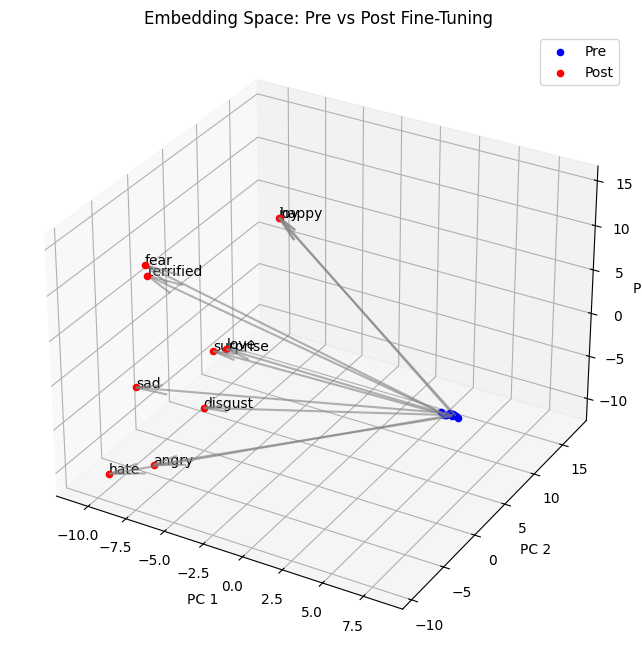

In [83]:
phrases = {
    "happy":    "I feel really happy today.",
    "sad":      "I’ve been feeling very sad lately.",
    "angry":    "She was extremely angry about what happened.",
    "joy":      "There was so much joy in the room.",
    "fear":     "He couldn’t hide the fear in his eyes.",
    "love":     "I love spending time with my family.",
    "hate":     "They hate being ignored by their friends.",
    "surprise": "Her reaction was a total surprise to everyone.",
    "disgust":  "He looked at the mess with pure disgust.",
    "terrified":  "He was terrified of flying during the storm."
}
words = list(phrases.keys())

# Embedding pre and post fine-tuning
embeddings_pre  = [get_sentence_embedding(phrases[word], tokenizer, model_pre) for word in words]
embeddings_fine = [get_sentence_embedding(phrases[word], tokenizer, model_fine) for word in words]

print(f"Length embeddings (pre fine-tuning): {len(embeddings_pre[0])}")
print(f"Length embeddings (post fine-tuning): {len(embeddings_fine[0])}")

# PCA
pca = PCA(n_components=3)
all_embeddings = np.vstack([embeddings_pre, embeddings_fine])
pca_embeddings = pca.fit_transform(all_embeddings)
embeddings_pre_3d  = pca_embeddings[:len(words)]
embeddings_fine_3d = pca_embeddings[len(words):]

# 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

for i, word in enumerate(words):
    ax.scatter(*embeddings_pre_3d[i], color='blue', label='Pre' if i == 0 else "")
    ax.scatter(*embeddings_fine_3d[i], color='red', label='Post' if i == 0 else "")
    ax.quiver(
        *embeddings_pre_3d[i],
        *(embeddings_fine_3d[i] - embeddings_pre_3d[i]),
        arrow_length_ratio=0.1, color='gray', alpha=0.6
    )
    ax.text(*embeddings_fine_3d[i], word, color='black')

ax.set_title('Embedding Space: Pre vs Post Fine-Tuning')
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')
ax.legend()
plt.show()

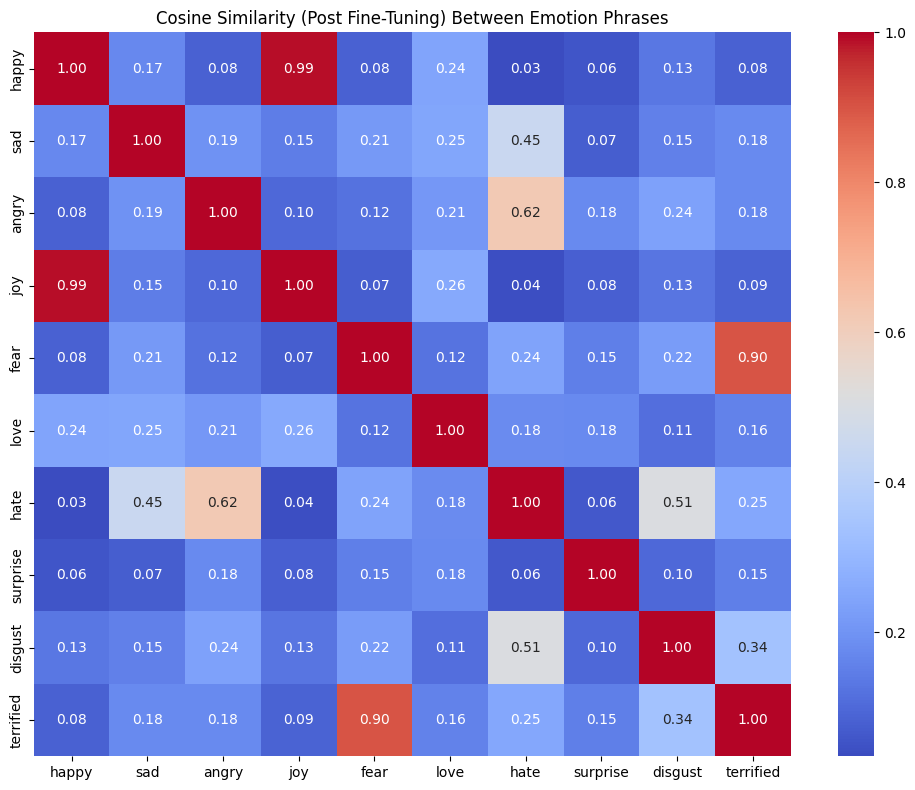

In [85]:
similarity_matrix = cosine_similarity(embeddings_fine)

# 3. Visualizzazione con heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix, xticklabels=words, yticklabels=words, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Cosine Similarity (Post Fine-Tuning) Between Emotion Phrases")
plt.tight_layout()
plt.show()

In the 3d plot, the embeddings of emotional words are shown before (blue points) and after (red points) fine-tuning the RoBERTa model. The arrows indicates the displacement vector for each embedding.

Before fine-tuning, the embeddings were highly concentrated and did not exhibit a clear sematic separation between different emotions. After fine-tuning, the words became more widely distributed in space: words associated with similar emotions (for example *happy* and *joy* or *angry* and *hate* or *fear* and *terrified*) tend to be positioned closer together.